# Acquisition via Jupyter Notebook
- ## Given a game_id, player_id and team_id => 
    ## get back df with a single player's 3pt shot info for a single game

In [6]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import time

# Endpoints from NBA API
from nba_api.stats.endpoints import playbyplayv2
from nba_api.stats.endpoints import gamerotation
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import teamplayerdashboard
from nba_api.stats.endpoints import winprobabilitypbp

# Static Imports from NBA API
from nba_api.stats.static import players
from nba_api.stats.static import teams

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.cluster import KMeans

# Helpful Stuff
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## *ACQUIRE TESTS*

In [7]:
import acquire_rm

Test "get_team_player_ids()" which creates a list of [team_id, player_id] needed for pulling shot data.

In [8]:
players_list = acquire_rm.get_team_player_ids()

Test "all_21_22_shots()" which creates a dataframe of all Regular season shots taken for the 2021-2022 season.

In [9]:
df_shots = acquire_rm.all_21_22_shots()

*Checked and abs_time function inside this shot acquirer worked properly.*

Create 3pt shot zones and find outliers

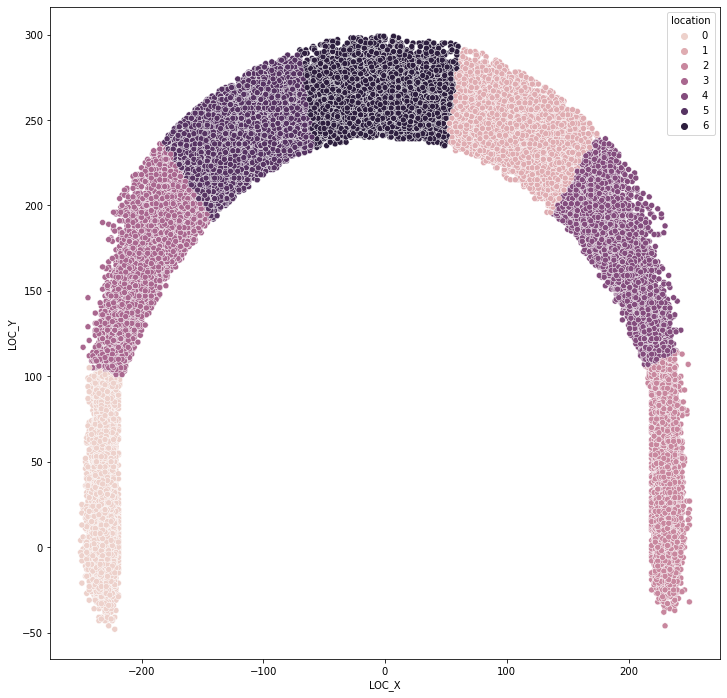

In [10]:
df_shots, df_outlier_3pt = acquire_rm.create_3pt_shot_zones(df_shots)

*Both dataframes returned properly*

Test shot acquisition function.

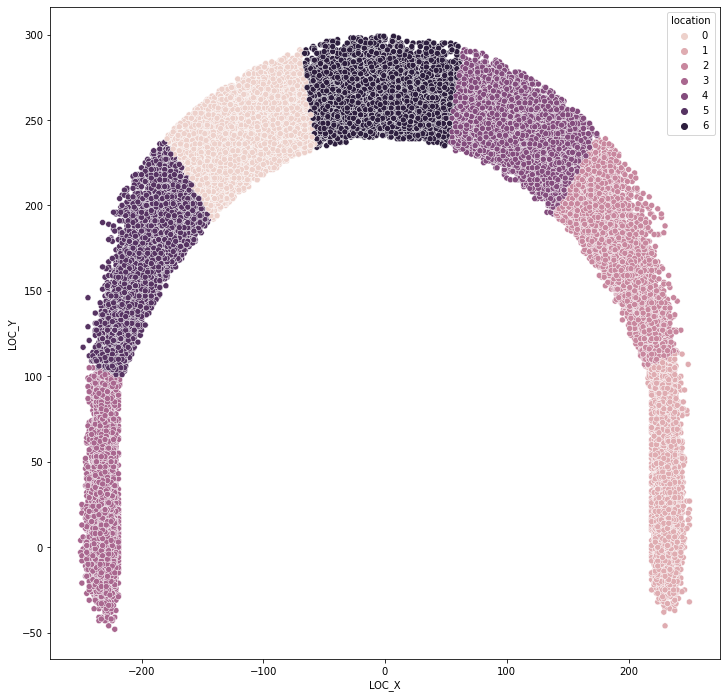

In [11]:
df_shots, df_outlier_3pt = acquire_rm.acquire_shots()

----

##### At this point, we need game_id and player_id for the game we want to analyze.

In [12]:
df_shots.sample(1)

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,abs_time,zone
204567,Shot Chart Detail,22100926,473,1628977,Hamidou Diallo,1610612765,Detroit Pistons,3,0,40,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,17,-143,96,1,0,20220301,WAS,DET,2120,NaN


In [13]:
game_id = '0022100748'
player_id = 200782

##### IMPORTANT NOTE: For df_base, game_id needs to be string with two leading zeros!

Creating the base for the player-game dataframe.

In [14]:
df_base = acquire_rm.create_base_df(game_id)

*Checked and abs_time function inside this game acquirer worked properly.*

While not yet used, let's check rotation data.

##### For rotation data, player_id needs to be an integer.

In [15]:
df_player_roto_times = acquire_rm.get_player_rotation_data(game_id, player_id)

In [16]:
df_player_roto_times

,abs_in_time,abs_out_time
0,0.0,487.0
1,1000.0,1901.0
2,2691.0,3780.0


Build player-gameline - one of two input dataframes

In [17]:
df_player_game = acquire_rm.build_player_gameline(df_player_roto_times, df_base)

Putting it all together:

In [20]:
df_player_game = acquire_rm.acquire_player_game(game_id, player_id)

1
2
3


,GAME_ID,EVENT_NUM,HOME_PCT,VISITOR_PCT,HOME_PTS,VISITOR_PTS,HOME_SCORE_MARGIN,PERIOD,SECONDS_REMAINING,HOME_POSS_IND,HOME_G,DESCRIPTION,LOCATION,PCTIMESTRING,ISVISIBLE,abs_time
0,0022100748,2.0,0.58808,0.41192,0,0,0,1,720.0,NaN,None,Start of 1st Period (8:10 PM EST),,12:00,1.0,0
1,0022100748,4.0,0.61352,0.38648,0,0,0,1,720.0,1.0,None,Jump Ball Adebayo vs. Barnes: Tip to Vincent,h,12:00,1.0,0
2,0022100748,NaN,0.61350,0.38650,0,0,0,1,719.0,1.0,None,None,None,None,NaN,1
3,0022100748,NaN,0.61348,0.38652,0,0,0,1,718.0,1.0,None,None,None,None,NaN,2
4,0022100748,NaN,0.61346,0.38654,0,0,0,1,717.0,1.0,None,None,None,None,NaN,3


----

Get the shot info for a single player in a single game.

In [ ]:
df_game_shots = acquire_rm.get_player_game_shots(game_id, player_id, df_shots)

Identify home tetam for feature adjustments.

In [ ]:
df_game_shots_h = acquire_rm.id_home_team(df_game_shots)

Combine the game shots with the player game dataframe

In [ ]:
df_player_game = acquire_rm.player_game(df_game_shots_h, df_player_game)

Works!

In [ ]:
df_player_game_target = acquire_rm.clean_game(df_player_game)

In [ ]:
df_player_game_target.info()

In [ ]:
df_player_game_target

In [21]:
# Turn a player name into a player_id

In [ ]:
# Get all games assocaited with that player_id and make into list

In [ ]:
# Create function that loops through all games in game_id list and combines with player_id to get
# the 3pt dataframes assocaited with that player 

### Acquire a dataframe with every shot taken in the 2021-2022 regular season.

Note: This will acquire and cache .csv in notebook directory

In [ ]:
filename = 'all_last_season_shots.csv'
if os.path.isfile(filename):
    df_all_shots =  pd.read_csv(filename, index_col=0)
else:
    df = pd.DataFrame()
    index = 0
    for player in players_list:
        print(f'\rFetching index {index} of 714', end='')
        df_pl = shotchartdetail.ShotChartDetail(team_id = player[0],
                                                        player_id = player[1],
                                                        season_type_all_star='Regular Season',
                                                        season_nullable='2021-22',
                                                        context_measure_simple = 'FG3A').get_data_frames()
        time.sleep(.5)
        index += 1
        df = pd.concat([df, df_pl[0]])
        df.to_csv(filename)

In [ ]:
df_all_shots

### Add 3pt cluster into shot dataframe (only for 3pt shots)

We first remove outliers - set up a df with only 3-pointers to find the iqr and use that to determine distance outliers

In [ ]:
df_all_shots = df_all_shots.reset_index(drop = True)

In [ ]:
df_all_3pt = df_all_shots[df_all_shots.SHOT_TYPE == '3PT Field Goal']

In [ ]:
low = df_all_3pt.SHOT_DISTANCE.quantile(.25)
high = df_all_3pt.SHOT_DISTANCE.quantile(.75)
add = (high-low) * 1.5
bound = high + add
bound

In [ ]:
df_outlier_3pt = df_all_3pt[df_all_3pt.SHOT_DISTANCE > 29.0]

In [ ]:
df_3pt = df_all_3pt[df_all_3pt.SHOT_DISTANCE <= 29.0]

In [ ]:
df_shots = df_all_shots[df_all_shots.SHOT_DISTANCE <= 29.0]

#### Now make them clusters

In [ ]:
X = df_3pt[['LOC_X','LOC_Y']]

In [ ]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)

clusters = kmeans.predict(X)

In [ ]:
df_3pt['3pt_location'] = clusters

In [ ]:
plt.figure(figsize = (12,12))
sns.scatterplot(data =df_3pt, x='LOC_X', y = 'LOC_Y', hue = '3pt_location')
plt.show()

Change location cluster names to descriptives

In [ ]:
df_3pt['3pt_location'] = df_3pt['3pt_location'].map({0: 'R Above Break', 1: 'L Above Break',2:'L Below Break/Corner',3:'R Center',4:'R Below Break/Corner',5:'Center',6:'L Center'})

In [ ]:
location_column = df_3pt[['3pt_location']]

In [ ]:
location_column


Merge to apply clusters to 3pt shots (all 2pt shots will be NaN)

In [ ]:
df_shots = df_shots.merge(location_column, how = 'left', left_index = True, right_index = True)

In [ ]:
df_shots

### Create a test Case:

In [ ]:
team_id = teams.find_team_by_abbreviation('SAS')['id'] # For SA Spurs

player_id = players.find_players_by_full_name("Keldon Johnson")[0]['id'] # For Keldon Johnson

game_id = '0022100010' # First game of year Spurs vs. Magic - note that game id must be converted to an int in df_shots

In [ ]:
player_id

### Start with the base of the analysis dataframe(s) - win probability

In [ ]:
# Select for a single game
df_base = winprobabilitypbp.WinProbabilityPBP(game_id).get_data_frames()[0]

Create linking column, 'absolute time' - game seconds since play started

In [ ]:
# Utilize user function to create absolute time (in seconds) column
df_base['abs_time'] = np.where(df_base.PERIOD <5,
                     ((df_base.PERIOD - 1) * 720 + (720 - df_base.SECONDS_REMAINING)),
                     (2880 + (df_base.PERIOD - 5) * 300 + (300 - df_base.SECONDS_REMAINING)))

### Rotation Dataframe (need this to get player minutes and minutes since rest)

In [ ]:
df_rotation = gamerotation.GameRotation(game_id).get_data_frames()

'Game Rotation' returns all the minutes (play time in the court) for every player in the game, seperated into Home and Visitor Dataframes.  As such we search through players for the records with our player_id.  Returns a dataframe holding their rotational stats, most importantly in_time and out_time.

In [ ]:
for i in range(2):
    for player in df_rotation[i].PERSON_ID:
        if player == player_id:
            df_player_roto = df_rotation[i][df_rotation[i].PERSON_ID == player]

We need to convert the rotational time in 1/10ths of second, into seconds, then isolate those times out.

In [ ]:
df_player_roto['abs_in_time'] = df_player_roto.IN_TIME_REAL/10
df_player_roto['abs_out_time'] = df_player_roto.OUT_TIME_REAL/10
df_player_roto_times = df_player_roto[['abs_in_time','abs_out_time']].reset_index(drop = 'True')

Create a list of zipped in_time and out_time (which bound active time on the court).

In [ ]:
zipped = list(zip(df_player_roto_times.abs_in_time, df_player_roto_times.abs_out_time))

In [ ]:
zipped

In [ ]:
for i in range(len(zipped)-1):
    print(zipped[i+1][0] - zipped[i][1])

Now filter out the times of the game (from df_base) that align with the player's play time.

In [ ]:
# Let me create a holder dataframe as I pull slices off from the base
df_player_game = pd.DataFrame()
for tuplez in zipped:
    df_slice = df_base[(df_base.abs_time >= tuplez[0]) & (df_base.abs_time <= tuplez[1])]
    df_player_game = pd.concat([df_player_game, df_slice])
df_player_game

In [ ]:
df_test = df_player_game.copy()

In [ ]:
# Need to create a way to track total playing time (we'll capture in seconds, even though NBA stat is 'minutes')
# df_test['in_game_seconds'] =

In [ ]:
# Need to create a way to track time since last break (we'll capture in seconds, even though NBA stat is 'minutes')
# df_test['seconds_since_rest'] = 

### To Do:
- Need to create columns with total time played and current time played.
- *Might* need to find and eliminate unecessary rows (i.e. SUBs, etc. - basically mutiple entries for a abs_time

#### Shot Details

In [ ]:
df_shots['abs_time'] = np.where(df_shots.PERIOD < 5,
                                (df_shots.PERIOD - 1) * 720 + (720 - (60 * df_shots.MINUTES_REMAINING) - (df_shots.SECONDS_REMAINING)),
                                2880 + ((df_shots.PERIOD - 5) * 300) + (300 - (60 * df_shots.MINUTES_REMAINING) - (df_shots.SECONDS_REMAINING)))

In [ ]:
df_game_shots = df_shots[df_shots.GAME_ID == int(game_id)]

In [ ]:
df_game_shots = df_game_shots[df_game_shots.PLAYER_ID == player_id]

In [ ]:
df_game_shots.reset_index(drop = True)

In [ ]:
teams.find_teams_by_full_name(df_game_shots.TEAM_NAME.max())[0]['abbreviation']

In [ ]:
df_game_shots['player_h_v'] = np.where(teams.find_teams_by_full_name(df_game_shots.TEAM_NAME.max())[0]['abbreviation'] == df_game_shots.HTM, 'Home', 'Visitor')

# Using current game df without seconds played and seconds since break

In [ ]:
df_almostthere = df_player_game.merge(df_game_shots, how = 'inner', on = 'abs_time')

In [ ]:
df_almostthere

In [ ]:
df_almostthere['play_points'] = np.where(df_almostthere.SHOT_TYPE == '2PT Field Goal',
                                    np.where(df_almostthere.SHOT_MADE_FLAG == 1, 2,0),
                                    np.where(df_almostthere.SHOT_MADE_FLAG == 1, 3,0))

In [ ]:
df_almostthere['points'] = df_almostthere['play_points'].cumsum()

In [ ]:
df_almostthere['shots_taken'] = df_almostthere['SHOT_ATTEMPTED_FLAG'].cumsum()
df_almostthere['shots_hit'] = df_almostthere['SHOT_MADE_FLAG'].cumsum()
df_almostthere['game_pct'] = round(df_almostthere['shots_hit']/df_almostthere['shots_taken'],2)

In [ ]:
df_almostthere.info()

In [ ]:
columns_to_drop = [
    'GAME_ID_x',
    'EVENT_NUM',
    'HOME_PTS',
    'VISITOR_PTS',
    'HOME_SCORE_MARGIN',
    'PERIOD_x',
    'SECONDS_REMAINING_x',
    'HOME_POSS_IND',
    'HOME_G',
    'LOCATION',
    'PCTIMESTRING',
    'ISVISIBLE',
    'GRID_TYPE',
    'GAME_EVENT_ID',
    'MINUTES_REMAINING',
    'SECONDS_REMAINING_y',
    'EVENT_TYPE',
    'SHOT_ZONE_BASIC',
    'SHOT_ZONE_AREA',
    'SHOT_ZONE_RANGE',
    'LOC_X',
    'LOC_Y',
    'SHOT_ATTEMPTED_FLAG',
    'SHOT_MADE_FLAG',
    'GAME_DATE',
    'HTM',
    'VTM']

In [ ]:
df_almostthere = df_almostthere.drop(columns = columns_to_drop)

In [ ]:
df_almostthere.info()

In [ ]:
columns_to_rename = {'WIN_PCT':'win_probability',
                     'DESCRIPTION':'play_description',
                     'GAME_ID_y':'game_id',
                     'PLAYER_ID':'player_id',
                     'PLAYER_NAME':'player',
                     'TEAM_ID':'team_id',
                     'TEAM_NAME':'team',
                     'PERIOD_y':'period',
                     'ACTION_TYPE':'shot_type',
                     'SHOT_TYPE':'2pt_or_3pt',
                     'SHOT_DISTANCE':'distance'}

In [ ]:
df_almostthere = df_almostthere.rename(columns = columns_to_rename)

In [ ]:
df_game_player_target = df_almostthere[df_almostthere['2pt_or_3pt'] == '3PT Field Goal']

### The returned stats for the game:

In [ ]:
df_game_player_target

### To do:
- Continue to assess and remove/clean/rename columns!

In [ ]:
df_outlier_3pt

In [ ]:
outlier_shots = pd.DataFrame(df_outlier_3pt['SHOT_DISTANCE'].value_counts())

In [ ]:
outlier_shots['pct'] = df_outlier_3pt.groupby('SHOT_DISTANCE').SHOT_MADE_FLAG.mean()

In [ ]:
outlier_shots = outlier_shots.rename(columns = {'SHOT_DISTANCE':'attempts'})
outlier_shots.index.name = 'distance (ft)'
outlier_shots['made'] = outlier_shots.attempts * outlier_shots.pct

In [ ]:
outlier_shots

Overall percentage of outliers made:

In [ ]:
outlier_shots.made.cumsum().max()/outlier_shots.attempts.cumsum().max()